In [240]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import os
import rasterio
import geopandas as gpd
from dbfread import DBF
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [209]:
# Path to the shapefile
shp_path = r'C:\\Users\liamr\Documents\Playground\river_plastic\data\Meijer2021_midpoint_emissions.shp'

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shp_path)

# Loading the .dbf file separately
dbf_path = r'C:\\Users\liamr\Documents\Playground\river_plastic\data\Meijer2021_midpoint_emissions.dbf'

dbf_data = DBF(dbf_path)


In [210]:
# Convert to pandas DataFrame
df = pd.DataFrame(iter(dbf_data))

# Inspect the columns in the .dbf file
print(df.columns)

# Check the first few rows of the data
# print(df.head())

Index(['dots_exten'], dtype='object')


In [211]:
# Display the first few rows to understand the structure of the data
print(gdf.head())

   dots_exten                     geometry
0    0.164904  POINT (168.79792 -46.58083)
1    0.124932  POINT (168.34875 -46.44708)
2    1.213370  POINT (168.33708 -46.41875)
3    0.121138  POINT (168.02125 -46.35792)
4    0.197533  POINT (169.81125 -46.34375)


In [212]:
print(gdf[['dots_exten', 'geometry']].head(20))  # Check the first 20 rows


    dots_exten                     geometry
0     0.164904  POINT (168.79792 -46.58083)
1     0.124932  POINT (168.34875 -46.44708)
2     1.213370  POINT (168.33708 -46.41875)
3     0.121138  POINT (168.02125 -46.35792)
4     0.197533  POINT (169.81125 -46.34375)
5     0.179718  POINT (170.19708 -46.05292)
6     0.382871  POINT (170.39208 -45.92875)
7     0.144652  POINT (170.50958 -45.88875)
8     0.593496  POINT (170.51708 -45.87542)
9     0.236202  POINT (171.25958 -44.42167)
10    0.102279  POINT (171.25708 -44.36125)
11    0.129572  POINT (171.35042 -44.28125)
12    0.376397  POINT (172.37875 -43.85625)
13    2.268480  POINT (172.75042 -43.55125)
14    2.850020  POINT (172.72458 -43.48792)
15    0.503895  POINT (172.70708 -43.39125)
16    0.207065  POINT (147.33792 -42.88375)
17    0.108960  POINT (147.45792 -42.77792)
18    0.499766  POINT (171.19208 -42.43875)
19    0.362587  POINT (174.06208 -41.50125)


In [213]:
# Sort by emission values and filter top 1000
top_1000_rivers = gdf.sort_values(by='dots_exten', ascending=False).head(1000)


In [214]:
top_1000_rivers.head()

,dots_exten,geometry
12639,62591.9,POINT (120.95708 14.59542)
12656,13450.2,POINT (120.94833 14.64958)
16880,13432.9,POINT (72.91292 19.28958)
13361,12816.0,POINT (101.38875 3.00292)
12693,12398.3,POINT (120.90042 14.71708)


In [215]:
# Define bounding box for Southeast Asia (latitude and longitude ranges)
southeast_asia_rivers = top_1000_rivers[
    (top_1000_rivers.geometry.y > 0) & (top_1000_rivers.geometry.y < 20) &
    (top_1000_rivers.geometry.x > 90) & (top_1000_rivers.geometry.x < 120)
]


In [216]:
southeast_asia_rivers.count()

dots_exten    176
geometry      176
dtype: int64

In [217]:
# Focusing on only SE Asia rivers - creating df
df = pd.DataFrame(southeast_asia_rivers)

# Create a geometry column
# df['geometry'] = df.apply(lambda x: Point(x['longitude'], x['latitude']), axis=1)

df['lon'] = df.geometry.apply(lambda p: round(p.x,5))
df['lat'] = df.geometry.apply(lambda p: round(p.y,5))

# # Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [218]:
# Optionally, check CRS and set it if needed
# df.crs = "EPSG:4326" 

In [219]:
df = df.rename(columns={'dots_exten': 'pollution_volume'})
df

,pollution_volume,geometry,lon,lat
13361,12816.000,POINT (101.38875 3.00292),101.38875,3.00292
14525,4127.440,POINT (106.74708 10.49875),106.74708,10.49875
15365,4027.330,POINT (100.55795 13.61573),100.55795,13.61573
16338,3615.390,POINT (96.19083 16.77458),96.19083,16.77458
7006,3274.700,POINT (110.39875 1.55542),110.39875,1.55542
...,...,...,...,...
14778,177.417,POINT (109.00929 11.54262),109.00929,11.54262
13473,176.705,POINT (100.61625 4.44625),100.61625,4.44625
15815,175.480,POINT (95.71042 16.07542),95.71042,16.07542
16334,174.970,POINT (96.12542 16.76208),96.12542,16.76208


### Visualising the map

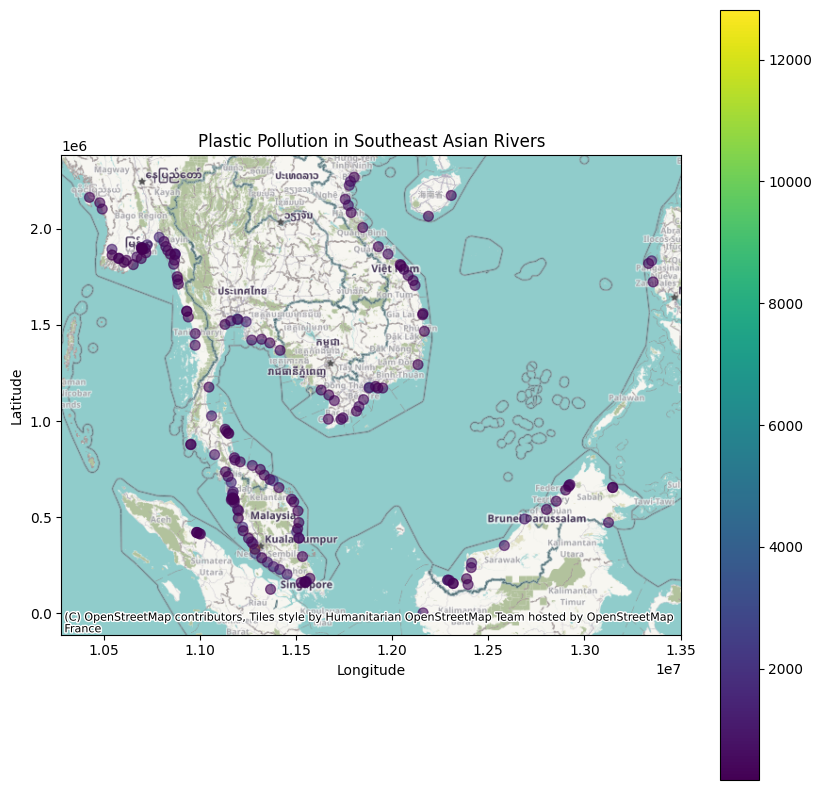

In [220]:
import matplotlib.pyplot as plt
import contextily as ctx

# Project to Web Mercator for better mapping with contextily
gdf = gdf.to_crs(epsg=3857)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the rivers
gdf.plot(column='dots_exten', ax=ax, legend=True,
         cmap='viridis', markersize=50, alpha=0.6)

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs)

# Set title and labels
ax.set_title('Plastic Pollution in Southeast Asian Rivers')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


- These are all the South-East rivers from the top 1000  -> 176 in total
- This project will aim to add a seasonal component to these rivers, with the focus on seasonal impacts on P(M) for simplicity

### Integrating Climate Data

- Obtaining precipitation data and wind data from WorldClim2
- Optional Enhancement: Land Use and Terrain Data -> from HYDROATLAS or GLAD Land Use
- Optional Enhancement: Waste Management Data -> The World Bank’s What a Waste database

Integration Plan:

- Integrate these as monthly variables tied to each river
- Historical climate averages then to be used to model how changes in precipitation and wind seasonally impact plastic mobilization P(M)

In [221]:
df

,pollution_volume,geometry,lon,lat
13361,12816.000,POINT (101.38875 3.00292),101.38875,3.00292
14525,4127.440,POINT (106.74708 10.49875),106.74708,10.49875
15365,4027.330,POINT (100.55795 13.61573),100.55795,13.61573
16338,3615.390,POINT (96.19083 16.77458),96.19083,16.77458
7006,3274.700,POINT (110.39875 1.55542),110.39875,1.55542
...,...,...,...,...
14778,177.417,POINT (109.00929 11.54262),109.00929,11.54262
13473,176.705,POINT (100.61625 4.44625),100.61625,4.44625
15815,175.480,POINT (95.71042 16.07542),95.71042,16.07542
16334,174.970,POINT (96.12542 16.76208),96.12542,16.76208


In [222]:
# Rank the rivers by plastic volume in descending order (higher plastic volume = higher rank)
df['rank'] = df['pollution_volume'].rank(ascending=False, method='dense').astype(int)

# Sort the DataFrame by rank if you want to see the order
df = df.sort_values(by='rank')

# top 10 polluting rivers in SE Asia
SE_top_10 = df.head(10)
SE_top_10_pts = SE_top_10[['lon', 'lat']]

In [242]:
# retrieving the country that each river belongs to and adding to the df
geolocator = Nominatim(user_agent="river_locator")


def get_country(lat, lon):
    location = geolocator.reverse((lat, lon), language='en')
    
    return location.raw.get('address', {}).get('country', None)


# Apply to DataFrame
SE_top_10_pts.loc[:, 'country'] = SE_top_10_pts.apply(lambda row: get_country(row['lat'], row['lon']), axis=1)

SE_top_10_pts


,lon,lat,country
13361,101.38875,3.00292,Malaysia
14525,106.74708,10.49875,Vietnam
15365,100.55795,13.61573,Thailand
16338,96.19083,16.77458,Myanmar
7006,110.39875,1.55542,Malaysia
13349,101.41125,2.80458,Malaysia
16367,96.10625,16.84125,Myanmar
13615,102.24458,6.18208,Malaysia
13414,103.34292,3.80625,Malaysia
13241,103.79750,1.49625,Malaysia


##### Next, want to add the historical weather data, from Climdata

In [230]:
# Rasterio is used to process the .tif file

# Directory where wind speed data files are all found
tif_wind_directory = r'C:\\Users\\liamr\\Documents\\Playground\\river_plastic\\data\\wc2.1_5m_wind'

# Organizing all the wind speed files in this director, so that it only contains tif files and is in chronological order
tif_wind_files = sorted([os.path.join(tif_wind_directory, f) for f in os.listdir(tif_wind_directory) if f.endswith('.tif')])


# Directory where precipitation data files are all found
tif_rain_directory = r'C:\\Users\\liamr\\Documents\\Playground\\river_plastic\\data\\wc2.1_5m_prec'

# Organizing all the wind speed files in this director, so that it only contains tif files and is in chronological order
tif_rain_files = sorted([os.path.join(tif_rain_directory, f) for f in os.listdir(tif_rain_directory) if f.endswith('.tif')])


In [231]:
tif_rain_files

['C:\\\\Users\\\\liamr\\\\Documents\\\\Playground\\\\river_plastic\\\\data\\\\wc2.1_5m_prec\\wc2.1_5m_prec_01.tif',
 'C:\\\\Users\\\\liamr\\\\Documents\\\\Playground\\\\river_plastic\\\\data\\\\wc2.1_5m_prec\\wc2.1_5m_prec_02.tif',
 'C:\\\\Users\\\\liamr\\\\Documents\\\\Playground\\\\river_plastic\\\\data\\\\wc2.1_5m_prec\\wc2.1_5m_prec_03.tif',
 'C:\\\\Users\\\\liamr\\\\Documents\\\\Playground\\\\river_plastic\\\\data\\\\wc2.1_5m_prec\\wc2.1_5m_prec_04.tif',
 'C:\\\\Users\\\\liamr\\\\Documents\\\\Playground\\\\river_plastic\\\\data\\\\wc2.1_5m_prec\\wc2.1_5m_prec_05.tif',
 'C:\\\\Users\\\\liamr\\\\Documents\\\\Playground\\\\river_plastic\\\\data\\\\wc2.1_5m_prec\\wc2.1_5m_prec_06.tif',
 'C:\\\\Users\\\\liamr\\\\Documents\\\\Playground\\\\river_plastic\\\\data\\\\wc2.1_5m_prec\\wc2.1_5m_prec_07.tif',
 'C:\\\\Users\\\\liamr\\\\Documents\\\\Playground\\\\river_plastic\\\\data\\\\wc2.1_5m_prec\\wc2.1_5m_prec_08.tif',
 'C:\\\\Users\\\\liamr\\\\Documents\\\\Playground\\\\river_plastic\\\\da

for every location, I need to extract the average wind speed and the average precipitation

In [283]:
# selecting the coordinates from the top polluting rivers
pts = SE_top_10_pts.copy()
pts.index = np.arange(1, len(pts) + 1)
coords = [(x,y) for x, y in zip(pts['lon'], pts['lat'])]

pts

,lon,lat,country
1,101.38875,3.00292,Malaysia
2,106.74708,10.49875,Vietnam
3,100.55795,13.61573,Thailand
4,96.19083,16.77458,Myanmar
5,110.39875,1.55542,Malaysia
6,101.41125,2.80458,Malaysia
7,96.10625,16.84125,Myanmar
8,102.24458,6.18208,Malaysia
9,103.34292,3.80625,Malaysia
10,103.79750,1.49625,Malaysia


In [282]:
# selecting the coordinates from the top polluting rivers
pts = SE_top_10_pts.copy()
pts.index = np.arange(1, len(pts) + 1)
coords = [(x,y) for x, y in zip(pts['lon'], pts['lat'])]

# Initialize an empty DataFrame for time series
time_series_data = []

# Iterate through each monthly wind and rain .tif file
# This pairs the corresponding wind and rain files and assignes them a number for each month
for month, (tif_wind_file, tif_rain_file) in enumerate(zip(tif_wind_files, tif_rain_files), start=1):  # Enumerate months from 1 to 12
    with rasterio.open(tif_wind_file) as src_wind:
        # Extract the raster values for all coordinates
        sampled_values_wind = [val[0] for val in src_wind.sample(coords)]

    with rasterio.open(tif_rain_file) as src_rain:
        # Extract raster values for all coordinates
        sampled_values_rain = [val[0] for val in src_rain.sample(coords)]


    # Create a DataFrame for the current month
    month_data = pd.DataFrame({
        'river_ID': pts.index,  # Adding unique IDs or indices for rivers. For top 10 SE rivers, this is in order of yearly plastic pollution
        'month': month,
        'avg_wind_speed': sampled_values_wind,
        'avg_precipitation': sampled_values_rain
    })
    # Finally, appending each month to the time_series_data DataFrame
    time_series_data.append(month_data)

time_series_data



[   river_ID  month  avg_wind_speed  avg_precipitation
 0         1      1        2.453425                179
 1         2      1        2.634000                  4
 2         3      1        1.987629                  9
 3         4      1        1.639744                  2
 4         5      1        2.109890                689
 5         6      1        2.176923                162
 6         7      1        1.401000                  2
 7         8      1        2.665000                141
 8         9      1        2.844445                332
 9        10      1        2.705000                204,
    river_ID  month  avg_wind_speed  avg_precipitation
 0         1      2        2.310959                130
 1         2      2        2.320000                  1
 2         3      2        2.094845                 17
 3         4      2        1.666667                  3
 4         5      2        2.023077                484
 5         6      2        2.346154                116
 6       

##### PROBLEM:
- This is long-term climate data, not more recent and varying weather patters month on month
- This is available for precipitation on WorldClim, but not for wind speed
- Will simplify the model for now, using only precipitation and potentially wind speed later on
- I will keep the above code for reference as it will be useful, but this cell will include code for more recent precipitation data

In [ ]:
# selecting the coordinates from the top polluting rivers
pts = SE_top_10_pts.copy()
pts.index = np.arange(1, len(pts) + 1)
coords = [(x,y) for x, y in zip(pts['lon'], pts['lat'])]

# Initialize an empty DataFrame for time series
time_series_data = []







In [271]:
time_series_data

[   river_ID  month  avg_wind_speed  avg_precipitation
 0         1     12        2.139726                230
 1         2     12        2.325000                 27
 2         3     12        2.253608                  6
 3         4     12        1.650000                 14
 4         5     12        2.154945                506
 5         6     12        2.096154                224
 6         7     12        1.535000                 14
 7         8     12        2.485000                553
 8         9     12        2.477778                669
 9        10     12        2.306250                308]

In [289]:
# Combine all monthly data into a single DataFrame (joining river pollution data onto WorldClim data)
time_series_df = pd.concat(time_series_data, ignore_index=True)


# Merge with the main `pts` DataFrame to include river metadata
final_df = pd.merge(time_series_df, pts, right_index=True, left_on='river_ID')

# Rearrange to how I want the table to be ordered
final_df = final_df[['month','river_ID','country','lon','lat','avg_precipitation','avg_wind_speed']]

In [285]:
sampled_values_wind

[np.float32(2.139726),
 np.float32(2.325),
 np.float32(2.2536082),
 np.float32(1.65),
 np.float32(2.1549451),
 np.float32(2.0961537),
 np.float32(1.535),
 np.float32(2.485),
 np.float32(2.4777777),
 np.float32(2.30625)]

#### This table provides a monthly breakdown of precipitation and wind at each of these locations

In [290]:
final_df[final_df['river_ID'] < 4]
# final_df

,month,river_ID,country,lon,lat,avg_precipitation,avg_wind_speed
0,1,1,Malaysia,101.38875,3.00292,179,2.453425
1,1,2,Vietnam,106.74708,10.49875,4,2.634000
2,1,3,Thailand,100.55795,13.61573,9,1.987629
10,2,1,Malaysia,101.38875,3.00292,130,2.310959
11,2,2,Vietnam,106.74708,10.49875,1,2.320000
12,2,3,Thailand,100.55795,13.61573,17,2.094845
20,3,1,Malaysia,101.38875,3.00292,200,2.034246
21,3,2,Vietnam,106.74708,10.49875,6,2.610000
22,3,3,Thailand,100.55795,13.61573,32,1.974227
30,4,1,Malaysia,101.38875,3.00292,211,1.802740


- Figure out why the wind speeds aren't varying
- Add a year component to this, so that time-series model can go back year by year

In [ ]:
time_series_df

,river_ID,month,avg_wind_speed
0,0,1,2.453425
1,1,1,2.634000
2,2,1,1.987629
3,3,1,1.639744
4,4,1,2.109890
...,...,...,...
115,5,12,2.096154
116,6,12,1.535000
117,7,12,2.485000
118,8,12,2.477778
